 # Gear Inspection

The machine vision based gear inspection task consist of following steps:
1. First step in any machine vison process is image acquisition.
2. Image preprocessing oprations for example blurring, soothing and image converstion etc.
3. Detecting contures for measurement of diameter.
4. Apply gear segmentation and morphological processes.
5. Obtaning gear teeth pixels.
6. Counting number of teeth using conture method.
7. Calculating diffrent parameters of gear from formulas by putting above value.
8. Checking surface of gear using CNN.
9. Appending all these values in text file.    


## Importing necessary modules
Imporing required libraries needed for program.

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

## Detecting and Measuring Diameter
This section of code analyzes an image of a gear by first resizing it and converting it to grayscale. Then, it applies edge detection to find the ededes of objects in the image. The largest outlined conture likely representing the gear, is identified. By measuring this area, the code estimates the gear's base diameter. Finally, the code shows the original image with the outlined gear and prints the estimated diameter.

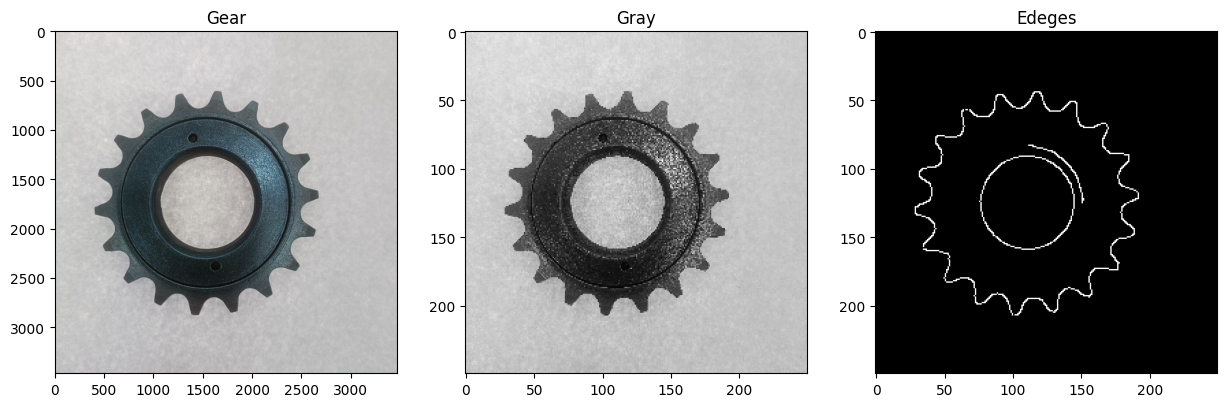

In [ ]:
img = cv.imread(r"D:\gear\g273.jpg")
dimension = (250,250)
image = cv.resize(img,dimension)

gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(gray,(11,11),0)
edges = cv.Canny(blurred, 50, 150)

contours, _ = cv.findContours(edges,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_NONE)
largest_contour = max(contours,key = cv.contourArea)
area = cv.contourArea(largest_contour)
base_diameter = area/109


plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize = (15, 12))
ax = plt.subplot(1, 3, 1)
plt.imshow(img,cmap = 'gray')
plt.title("Gear")

ax = plt.subplot(1, 3, 2)
plt.imshow(gray)
plt.title("Gray")

ax = plt.subplot(1, 3, 3)
plt.imshow(edges)
plt.title("Edeges")

plt.show()



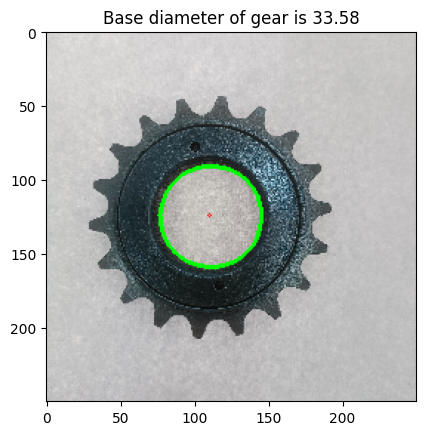

In [ ]:
base_diameter_of_gear = image.copy()
cv.drawContours(base_diameter_of_gear, largest_contour,-1,(0,255,0),2)
(x, y), radius = cv.minEnclosingCircle(largest_contour)
cv.circle(base_diameter_of_gear, (int(x), int(y)), int(1), (255,0,0), 1)

plt.imshow(base_diameter_of_gear)
plt.title(f'Base diameter of gear is {base_diameter:.2f}')
plt.show()

## Conting Number of Teeth
This section of code convert image to binary using otsu thresholding. in otsu thresholding it calculate threshold value based on image. after calculating theshold value it disply it along this threshold image.

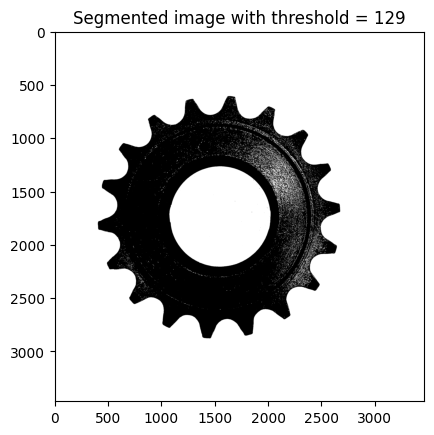

In [ ]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray =  cv.GaussianBlur(gray, (1,1), 0)
(thres, bw) = cv.threshold(gray, 150, 255, cv.THRESH_OTSU)

plt.imshow(bw)
plt.title(f"Segmented image with threshold = {int(thres)}")
plt.show()

After threshloding there is white hole in middle, but we need complete black image of gear to perform morphological opening opration.to fill in the remaining holes and noises.
1. Detect the holes by flood filling the background of the binary image.
2.
Invert flooded image to match the binary gear image
3.
Fill the holes by adding the inverse flooded image to the binary image.

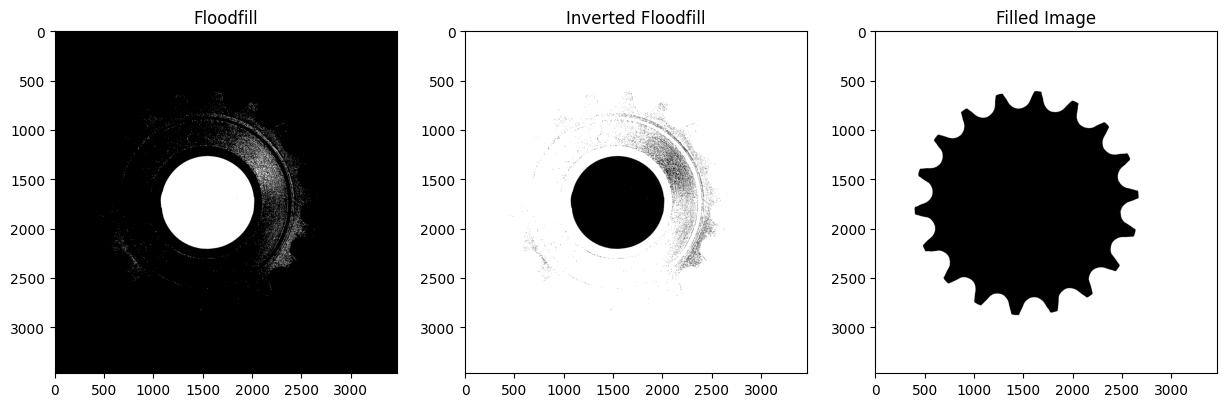

In [ ]:
floodfill = bw.copy()
h, w = bw.shape[:2]
mask = np.zeros((h + 2, w + 2), np.uint8)
cv.floodFill(floodfill, mask, (0,0), 0);
floodfill_inv = cv.bitwise_not(floodfill)
fill = bw & floodfill_inv

plt.figure(figsize = (15, 12))
ax = plt.subplot(1, 3, 1)
plt.imshow(floodfill)
plt.title("Floodfill")

ax = plt.subplot(1, 3, 2)
plt.imshow(floodfill_inv)
plt.title("Inverted Floodfill")

ax = plt.subplot(1, 3, 3)
plt.imshow(fill)
plt.title("Filled Image")

plt.show()

Image undergo Morphological opening opration. In this opration first it errode the image that make object in image smaller and then perform dilation opration which make object larger getting following image.

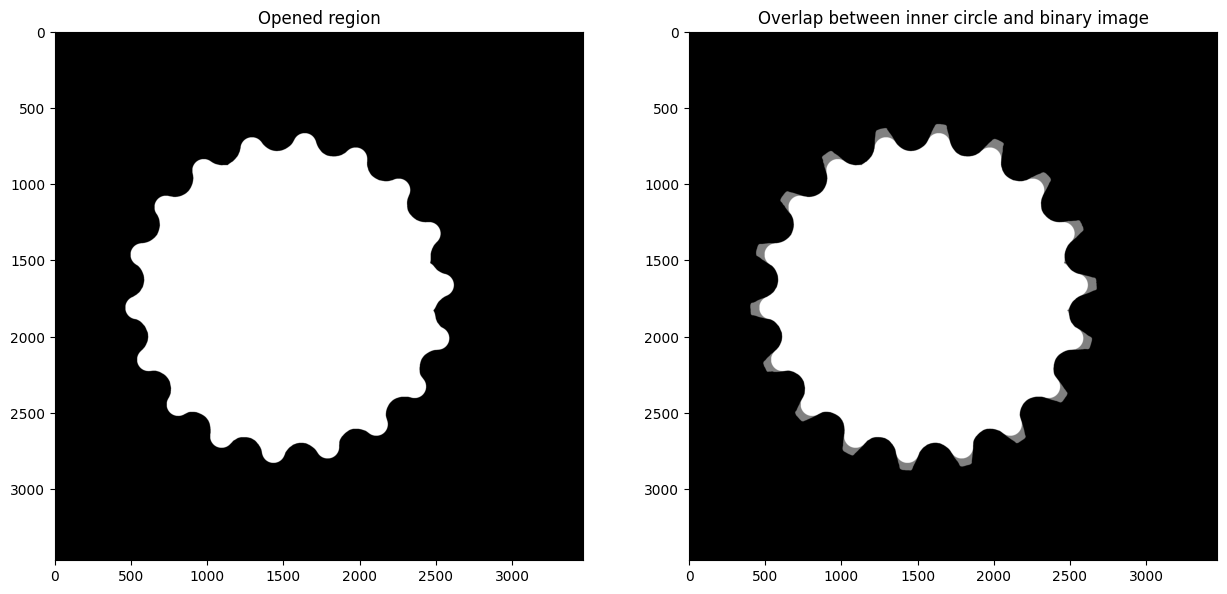

In [ ]:
fill = cv.bitwise_not(fill)
kernel = cv.getStructuringElement(shape = cv.MORPH_ELLIPSE, ksize = (150,150))
open = cv.morphologyEx(fill, cv.MORPH_OPEN, kernel)

plt.figure(figsize = (15, 12))
plt.subplot(1, 2, 1)
plt.imshow(open)
plt.title("Opened region")

plt.subplot(1, 2, 2)
overlap = cv.addWeighted(fill, 0.5, open, 0.5, 0.0)
plt.imshow(overlap)
plt.title("Overlap between inner circle and binary image")
plt.show()

After getting teeth of image, counting teeth using dialation and conture method as done in diameter section.

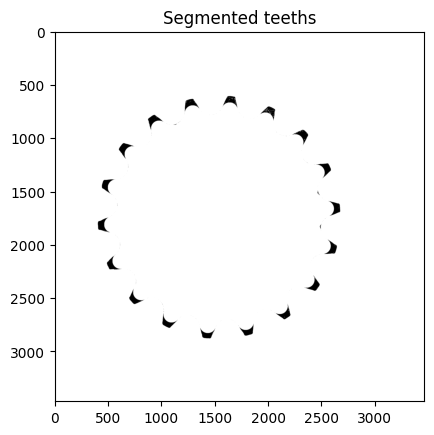

In [ ]:
img_cogs = open | bw
plt.imshow(img_cogs)
plt.title("Segmented teeths")
plt.show()

_, thresholded = cv.threshold(img_cogs, 127, 255, cv.THRESH_BINARY_INV)
kernel = np.ones((5,5),np.uint8)
dilated = cv.dilate(thresholded, kernel, iterations = 1)

contours, _ = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
min_area = 500
gears = []

for contour in contours:
    area = cv.contourArea(contour)
    if area > min_area:
        gears.append(contour)

number_of_teeth = len(gears)


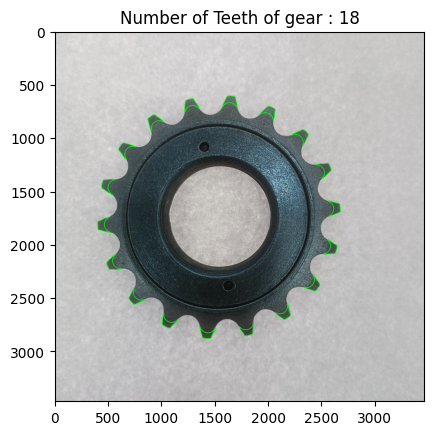

In [ ]:
num_of_teeth_img = img.copy()
test = cv.drawContours(num_of_teeth_img,gears,-1,(0,255,0),thickness=5)

plt.imshow(num_of_teeth_img)
plt.title(f'Number of Teeth of gear : {number_of_teeth}')
plt.show()

## Calculating and Displaying other Parameter of Gear

In [ ]:
outer_diameter = 78.3
module = outer_diameter/(2+ number_of_teeth)

pitch = np.pi*module

pitch_circle_diameter = module * number_of_teeth


actual_inner_dia = 33.8
actual_outer_dia = 78.7
actual_pitch = 12.7
actual_module = 3.935
actual_teeth = 18
actual_pitch_dia = 70.83

table = PrettyTable()

table.field_names = ["Parameter", "Orignal size (mm)", "Measured by Machne vision (mm)", "Difference between MVS and orignal (mm)"]

table.add_rows([
    ["Di",actual_inner_dia, base_diameter, actual_inner_dia - base_diameter ],
    ["Do", actual_outer_dia, outer_diameter, actual_outer_dia - outer_diameter],
    ["D", actual_pitch_dia, pitch_circle_diameter, actual_pitch_dia - pitch_circle_diameter],
    ["t", actual_teeth, number_of_teeth, actual_teeth - number_of_teeth ],
    ["m", actual_module, module, actual_module - module],
    ["p", actual_pitch, pitch, actual_pitch - pitch],
])

print(table)

+-----------+-------------------+--------------------------------+-----------------------------------------+
| Parameter | Orignal size (mm) | Measured by Machne vision (mm) | Difference between MVS and orignal (mm) |
+-----------+-------------------+--------------------------------+-----------------------------------------+
|     Di    |        33.8       |       33.57798165137615        |           0.22201834862384828           |
|     Do    |        78.7       |              78.3              |            0.4000000000000057           |
|     D     |       70.83       |             70.47              |           0.35999999999999943           |
|     t     |         18        |               18               |                    0                    |
|     m     |       3.935       |             3.915              |           0.020000000000000018          |
|     p     |        12.7       |       12.29933523880404        |            0.4006647611959586           |
+-----------+------

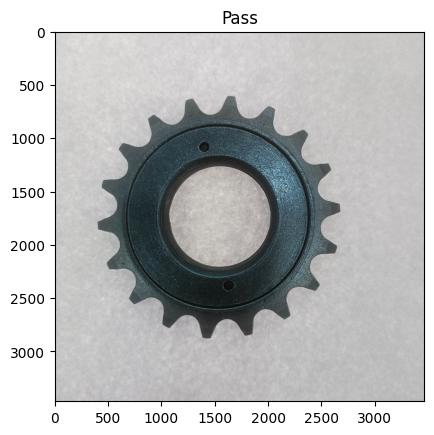

In [ ]:
a = actual_inner_dia - base_diameter
b = actual_outer_dia - outer_diameter
c = actual_pitch_dia - pitch_circle_diameter
d = actual_teeth - number_of_teeth
e = actual_module - module
f = actual_pitch - pitch

result = img.copy()

if a > 0.5 or b > 0.5 or c > 0.5 or d > 0.5 or e > 0.5 or f > 0.5:
    result_title = 'Fail'
else:
    result_title = 'Pass'

plt.imshow(result)
plt.title(result_title)
plt.show()